## AutoEncoder (AE) 及其所衍生的類神經網路

### 一、種類:

#### 1. Autoencoder (AE)   

- Examples: Undercomplete AutoEncoder、Stacked AutoEncoder ...

#### 2. Variational Autoencoder (VAE)

#### 3. Denoising Autoencoder (DAE)

#### 4. Sparse Autoencoder (SAE)

### 二、共同特徵:

#### 1. 屬於非監督式學習

#### 2. 結構:

    [Original input] -> [Encoder] ->  [Compressed representation] ->  [Decoder] -> [Reconstructed input]

#### 3. 輸入與輸出的神經元數目必須相同

### 三、AutoEncoder (AE) 的一些應用:

#### 1. 降維 (Dimensionality reduction)

#### 2. 特徵擷取 (Feature extraction)、信息檢索 (Information retrieval)

#### 3. 資料視覺化

#### 4. 非監督式預先訓練 (Unsupervised pre-training for DNN)

#### 5. 生成模型 (Generative models)

#### 6. 異常偵測 (Anomaly detection)

## Denoising Autoencoder (DAE) 

#### 1. 說明: 為學習對圖片去噪(denoise)的神經網絡

#### 2. 做法: 在輸入資料中加入隨機的雜訊(noise)，然後使它回復到原始無噪聲的資料，讓模型學會去噪的能力

#### 3. DAE 的結構:

    [Noisy input] -> [Encoder] ->  [Compressed representation] ->  [Decoder] -> [Denoised output]

### 一、執行 TensorFlow 與 Keras 模組

In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4


Using TensorFlow backend.


### 二、Keras 下載 MNIST 辨識資料集

In [2]:
import numpy as np
import pandas as pd
# 此模組要將 label 轉換成 one-hot-coding
from keras.utils import np_utils
# 匯入用來下載 mnist 資料的模組
from keras.datasets import mnist

# 下載 mnist 資料 (資料儲存在 C:\Users\user\.keras 資料夾)
(x_train_image, t_train_label), (x_test_image, t_test_label) = mnist.load_data()

# 查看 mnist 資料筆數
print('x train data = ', len(x_train_image))
print('t train data = ', len(t_train_label))
print('x test data = ', len(x_test_image))
print('t test data = ', len(t_test_label))
print('-----------------------------------')

# 查看訓練資料
print('x_train_image:', x_train_image.shape)
print('t_train_label:', t_train_label.shape)
print('-----------------------------------')

# 查看測試資料
print('x_test_image:', x_test_image.shape)
print('t_test_label:', t_test_label.shape)
print('-----------------------------------')

x train data =  60000
t train data =  60000
x test data =  10000
t test data =  10000
-----------------------------------
x_train_image: (60000, 28, 28)
t_train_label: (60000,)
-----------------------------------
x_test_image: (10000, 28, 28)
t_test_label: (10000,)
-----------------------------------


顯示圖形影像

顯示訓練資料前五個影像:


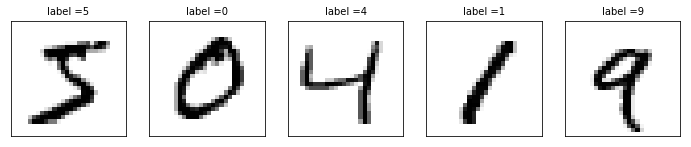

---------------------------------------------------------------------------------------------
顯示測試資料前五個影像:


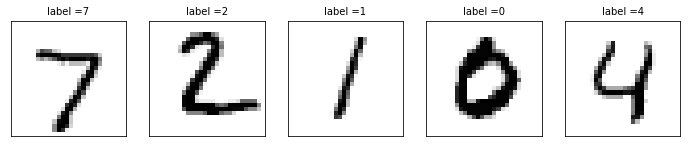

---------------------------------------------------------------------------------------------


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# 定義顯示資料的函數
def plot_image_label_prediction(images, labels, prediction, idx, num = 5):
    # 設定圖形的大小
    fig = plt.gcf()
    fig.set_size_inches(12, 15)
    
    if num > 10: num = 10
    
    for i in range(0, num):
        # 建立子圖為 2 行 5 列
        ax = plt.subplot(2, 5, 1+i)
        # 畫出子圖形
        ax.imshow(images[idx], cmap = 'binary')
        # 子圖 title 名稱
        title = 'label =' + str(labels[idx])
        # 若有預測資料，則顯示預測結果
        if len(prediction) > 0:
            title += ',predict =' + str(prediction[idx])
        
        ax.set_title(title, fontsize = 10)
        ax.set_xticks([])
        ax.set_yticks([])
        
        idx += 1
        
    plt.show()
    
# 顯示訓練資料前五個影像
print('顯示訓練資料前五個影像:')
plot_image_label_prediction(x_train_image, t_train_label, [], 0, 5)
print('---------------------------------------------------------------------------------------------')

# 顯示測試資料前五個影像
print('顯示測試資料前五個影像:')
plot_image_label_prediction(x_test_image, t_test_label, [], 0, 5)
print('---------------------------------------------------------------------------------------------')

### 三、Keras 執行 DAE model

#### 1. 資料預處理 (Preprocess)

In [4]:
# 將 (60000, 28, 28) 的影像大小轉換成 60000*28*28*1 的四維矩陣
x_train4D = x_train_image.reshape(x_train_image.shape[0], 28, 28, 1).astype('float32')
x_test4D = x_test_image.reshape(x_test_image.shape[0], 28, 28, 1).astype('float32')

# 將 feature 歸一化
x_train4D_normalize = x_train4D / 255
x_test4D_normalize = x_test4D / 255

# 加入隨機 noise
noise_factor = 0.5
# numpy.random.normal 函數裡的三個參數分别代表生成的高斯分布的均值、標準差以及輸出的 size
x_train4D_normalize_noise = x_train4D_normalize + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train4D_normalize.shape)
x_test4D_normalize_noise = x_test4D_normalize + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test4D_normalize.shape)

# 把數值限制在一定範圍内 (0 ~ 1)
x_train_nn = np.clip(x_train4D_normalize_noise, 0., 1.)  
x_test_nn = np.clip(x_test4D_normalize_noise, 0., 1.)

#### 2. 建立 DAE 模型

In [5]:
# 匯入所需的模組
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# 建立線性堆疊模型(骨架)
model = Sequential()

# 建立 encoder
# 建立輸入層與卷積層 1
# 參數說明: filters (濾鏡數目)，kernel_size (濾鏡大小)，
# padding (填充的大小)，input_shape (輸入影像的形狀), activation (活化函數)          
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same',
                 input_shape = (28, 28, 1), activation = 'relu'))

# 建立池化層 1
# 參數說明: pool_size (池化層的形狀大小)
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))

# 建立卷積層 2
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'))

# 建立池化層 2
encoded = model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
#----------------------------------------------------------------------------------------------------
# 建立 decoder
# 建立卷積層 3
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'))

# 建立 UpSampling2D layer 1
model.add(UpSampling2D(size = (2, 2)))

# 建立卷積層 4
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'))

# 建立 UpSampling2D layer 2
model.add(UpSampling2D(size = (2, 2)))

decoded = model.add(Conv2D(filters = 1, kernel_size = (3, 3), padding = 'same', activation = 'sigmoid'))

# 查看模型摘要
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv

#### 3. 進行神經網路的訓練

In [6]:
# 定義訓練方式
# 參數說明: loss (損失函數)，optimizer (最佳化的方法)
model.compile(loss = 'binary_crossentropy', optimizer = 'adadelta')

# 開始訓練
# 參數說明: x, y (輸入的資料)，validation_split (驗證資料的比例)，shuffle (隨機打亂數據)
# epochs (訓練週期)， batch_size (批次數量)，verbose (顯示訓練的過程)
train_history = model.fit(x = x_train_nn, y = x_train4D_normalize, validation_split = 0.2, 
                         shuffle = True, epochs = 10, batch_size = 200, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 97s - loss: 0.2454 - val_loss: 0.1602
Epoch 2/10
 - 97s - loss: 0.1462 - val_loss: 0.1412
Epoch 3/10
 - 102s - loss: 0.1333 - val_loss: 0.1339
Epoch 4/10
 - 103s - loss: 0.1258 - val_loss: 0.1240
Epoch 5/10
 - 98s - loss: 0.1212 - val_loss: 0.1186
Epoch 6/10
 - 96s - loss: 0.1180 - val_loss: 0.1175
Epoch 7/10
 - 96s - loss: 0.1155 - val_loss: 0.1168
Epoch 8/10
 - 96s - loss: 0.1138 - val_loss: 0.1121
Epoch 9/10
 - 96s - loss: 0.1123 - val_loss: 0.1128
Epoch 10/10
 - 97s - loss: 0.1111 - val_loss: 0.1090


#### 4. 圖形顯示訓練過程

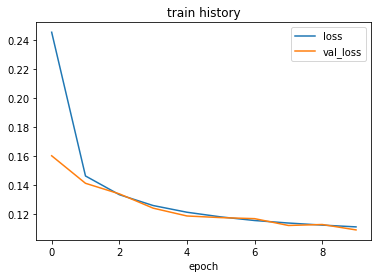

In [7]:
import matplotlib.pyplot as plt

def show_train_history(train_history):
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('train history')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc = 'upper right')
    plt.show()
    
# loss function 的變化    
show_train_history(train_history)

#### 5. 比較含雜訊的輸入影像和去雜訊的輸出影像

顯示測試資料前五個包含雜訊的影像:


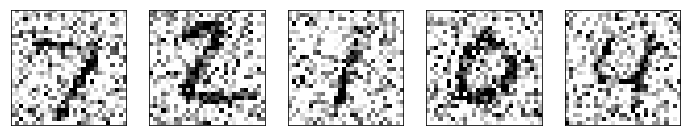

-----------------------------------------------------------------------------------------
10000/10000 [==============================] - 5s 488us/step
-----------------------------------------------------------------------------------------
顯示測試資料前五個去除雜訊的影像:


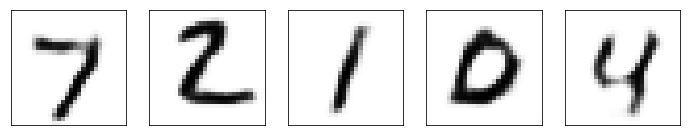

-----------------------------------------------------------------------------------------


In [8]:
import matplotlib.pyplot as plt

def plot_image(images, idx, num = 5):
    # 設定圖形的大小
    fig = plt.gcf()
    fig.set_size_inches(12, 15)
    
    if num > 10: num = 10
    
    for i in range(0, num):
        # 建立子圖為 2 行 5 列
        ax = plt.subplot(2, 5, 1+i)
        # 畫出子圖形
        ax.imshow(images[idx], cmap = 'binary')
        ax.set_xticks([])
        ax.set_yticks([])
        
        idx += 1
        
    plt.show()

test_nn_img = x_test_nn.reshape(x_test_nn.shape[0], 28, 28)

# 顯示測試資料前五個包含雜訊的影像
print('顯示測試資料前五個包含雜訊的影像:')
plot_image(test_nn_img, 0, 5)
print('-----------------------------------------------------------------------------------------')    

output_normalize = model.predict(x_test_nn, batch_size = 200, verbose = 1, steps = None)
output = output_normalize * 255
denoised_test_images = output.reshape(output.shape[0], 28, 28).astype('uint8')

# 顯示測試資料前五個去除雜訊的影像
print('-----------------------------------------------------------------------------------------')    
print('顯示測試資料前五個去除雜訊的影像:')
plot_image(denoised_test_images, 0, 5)
print('-----------------------------------------------------------------------------------------')    

#### Reference: 
- [Keras: 基於Python 的深度學習庫](https://keras.io/zh/)



- [Convolutional autoencoder & Application to image denoising](https://blog.keras.io/building-autoencoders-in-keras.html)